In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from highlight_initializer import *
from baseline_evaluation import evaluate_baseline
from utils import *
import copy
from highlight_extractor import *
from parameters import *
import warnings
warnings.filterwarnings("ignore")

/home/ruochenj/Desktop/Lightor_Exp/ENV/lib/python3.5/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Loading datasets

In [2]:
dota2_train_data = DataLoader('Dota2', 'train', **INITIAL_PARA)
dota2_test_data = DataLoader('Dota2', 'test', **INITIAL_PARA)
lol_train_data = DataLoader('LOL', 'train', **INITIAL_PARA)
lol_test_data = DataLoader('LOL', 'test', **INITIAL_PARA)

# Training models

In [3]:
dota2_model1 = train(dota2_train_data, [0])
dota2_model3 = train(dota2_train_data, [0, 1, 2])
dota2_model2 = train(dota2_train_data, [0, 1])
lol_model = train(lol_train_data, [0, 1, 2])

all_training_files = dota2_train_data.chat_filename_list
other_models = []
training_data = []
for i in range(1, 11):
    subfiles = all_training_files[:i]
    training_data.append(DataLoader('Dota2', 'train', subfiles=subfiles, **INITIAL_PARA))
    other_models.append(train(training_data[-1], [0, 1, 2]))
expander = Adjustment(dota2_train_data, **EXPAND)
expander.train()

In [4]:
expander.const

[25, 19]

# Parameter Exp

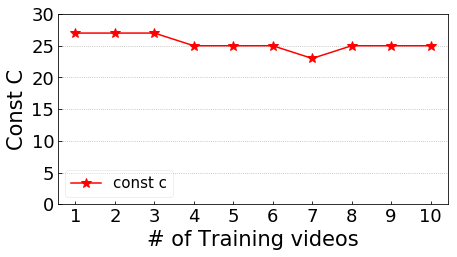

[27, 27, 27, 25, 25, 25, 23, 25, 25, 25]


In [5]:
const_c = []
for d in training_data:
    e = Adjustment(d, **EXPAND)
    e.train()
    const_c.append(e.const[0])
plot_precision([[const_c, '-r*', 'const c']], '# of Training videos', 'Const C', list(range(1, 11)), [0, 30], np.arange(0, 35, 5))
print(const_c)

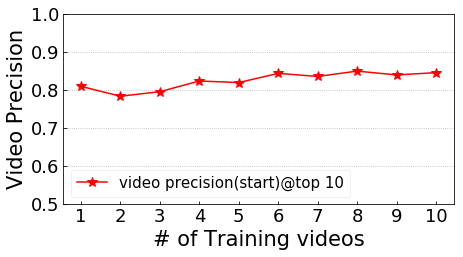

[0.81, 0.784, 0.796, 0.824, 0.82, 0.844, 0.836, 0.85, 0.84, 0.846]


In [6]:
prec = []
for m in other_models:
    test = deepcopy(dota2_test_data)
    apply_model(m, test, 120, [4, 5, 6])
    true_num = 0
    for f in test.chat:
        pred = test.predicted_labels[f][:10]
        true_num += len([p for p in pred if time(p) in test.baseline_gt[f]])
    prec.append(true_num / (10 * len(test.chat)))
plot_precision([[prec, '-r*', 'video precision(start)@top 10']], '# of Training videos', 'Video Precision', list(range(1, 11)), [0.5, 1.0], [0.5,0.6,0.7,0.8,0.9,1.0])
print(prec)

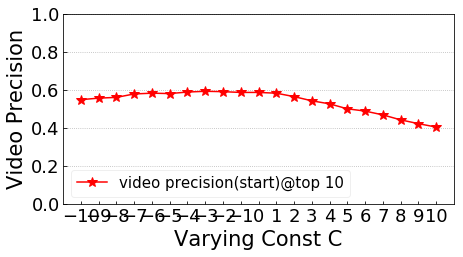

[0.55, 0.558, 0.562, 0.58, 0.584, 0.582, 0.59, 0.594, 0.592, 0.588, 0.588, 0.584, 0.566, 0.544, 0.528, 0.502, 0.49, 0.47, 0.444, 0.424, 0.406]


In [7]:
expander = Adjustment(dota2_train_data, **EXPAND)
expander.train()
optimal = expander.const[0]
test = deepcopy(dota2_test_data)
c_list = list(range(-10, 11, 1))
apply_model(dota2_model3, test, 120, [4, 5, 6])
expander.generate_peaks(test, **EXPAND)
prec = [0] * 21
for i, c in enumerate(c_list):
    expander.const[0] = optimal + c
    expander.apply(test)
    for f in test.predicted_labels:
        prec[i] += len([p for p in test.predicted_labels[f][:10] if p[-1] in test.start_gt[f]])
    prec[i] /= 500
plot_precision([[prec, '-r*', 'video precision(start)@top 10']], 'Varying Const C', 'Video Precision', list(range(-10, 11)), [0, 1.0], np.arange(0.0, 1.1, 0.2))
print(prec)

# Exp for Figure 2(a)

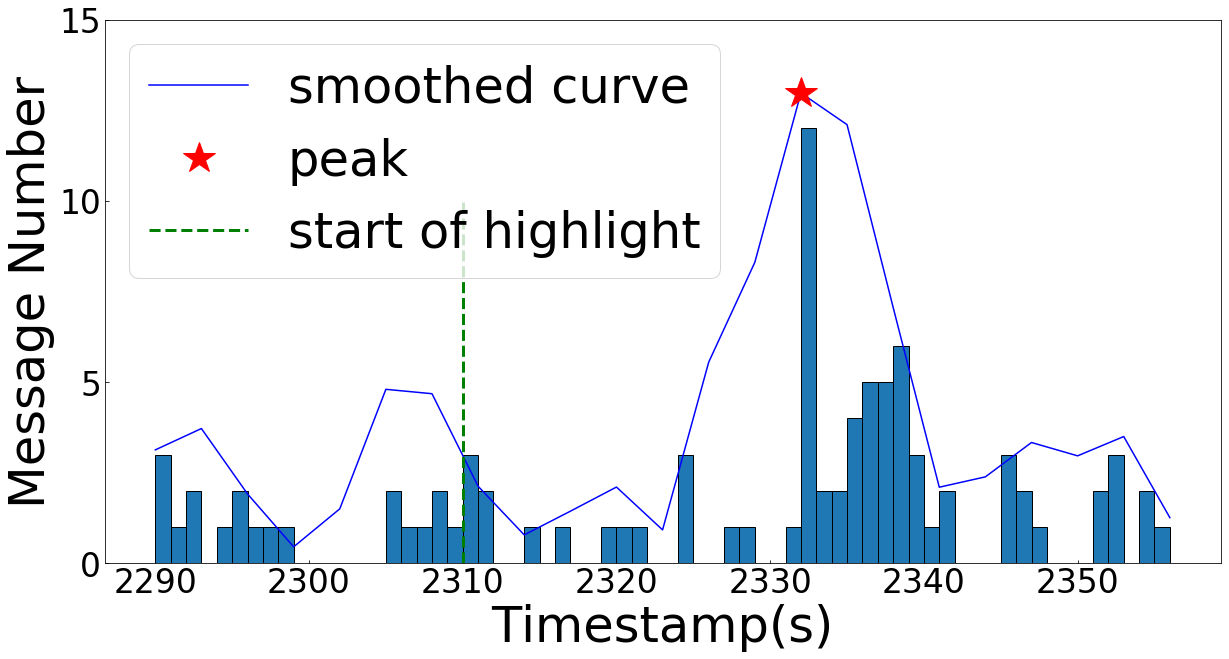

In [8]:
selected_file = 'sing_sing-2017-08-01-09h09m34s'
selected_time = ['038-42', '038-30', '038-45']
plot_peak(dota2_test_data, selected_file, sec(selected_time[0]), sec(selected_time[1]))

# Exp for Figure 2(b)

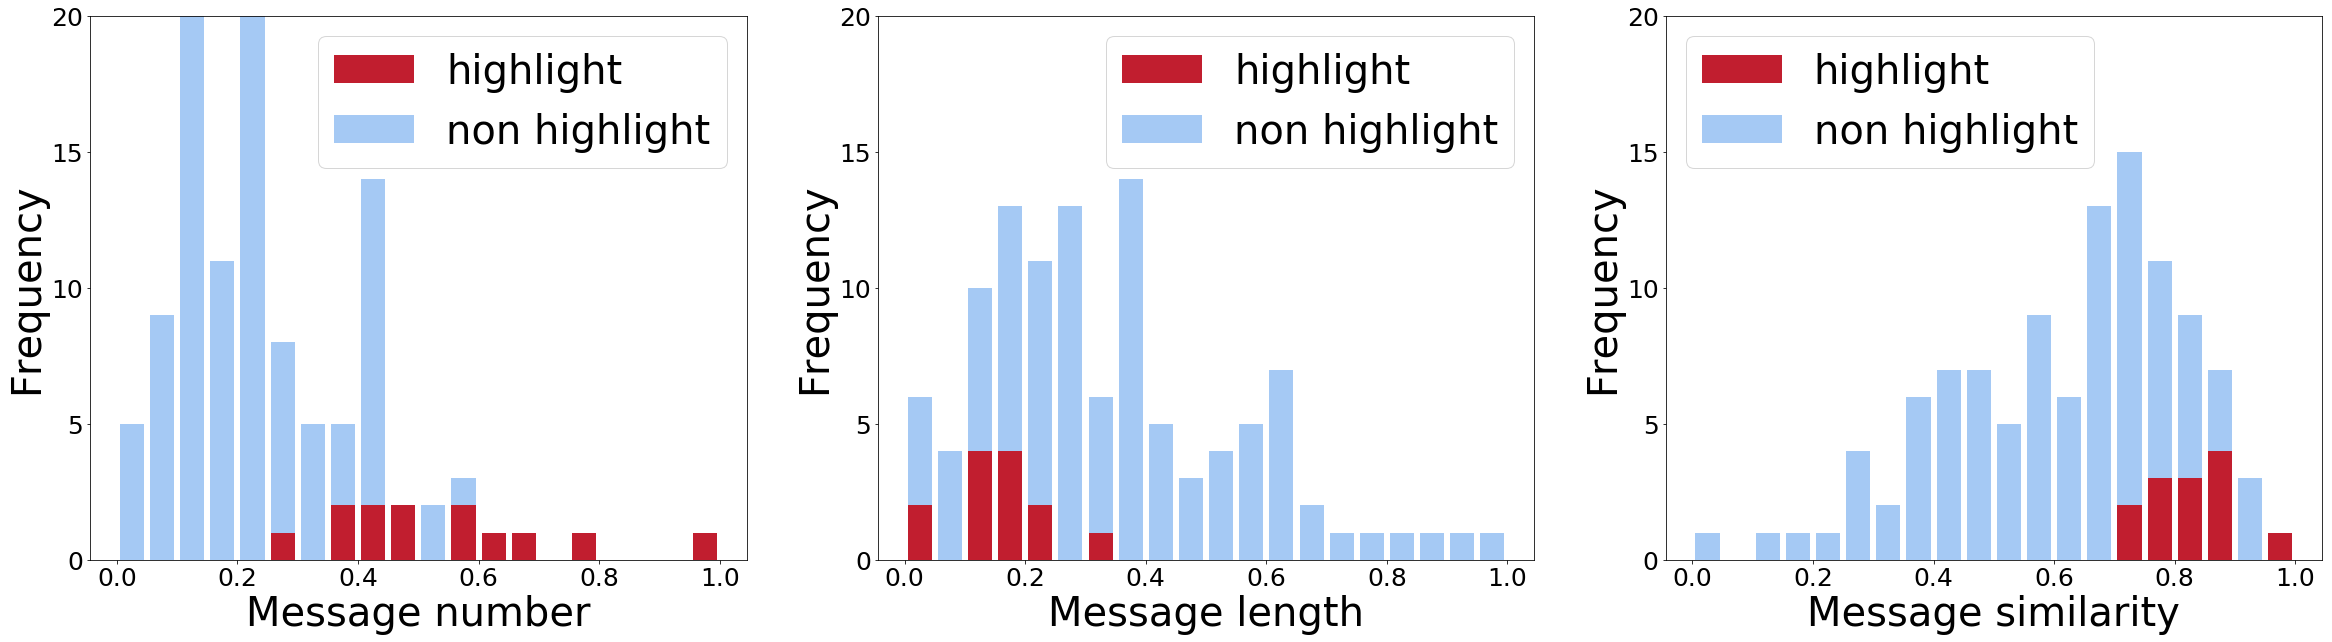

In [9]:
show_features(training_data[0])

# Exp for Figure 3

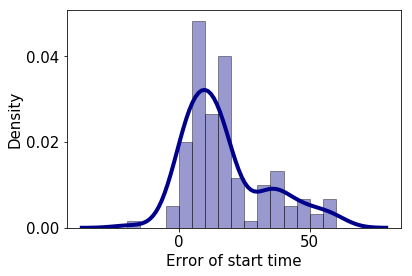

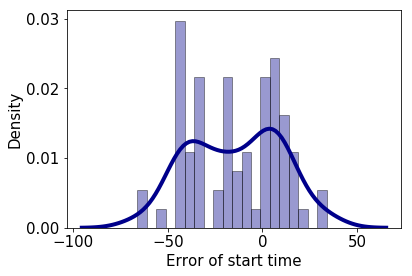

In [10]:
plot_behaviors("1")
plot_behaviors("2")

# Exp for Figure 6(a)

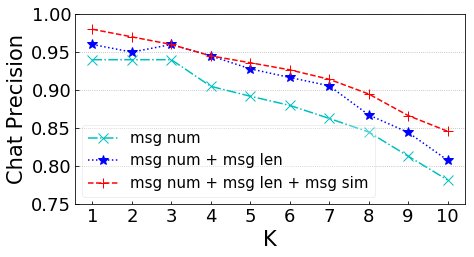

[[[0.94, 0.94, 0.94, 0.905, 0.892, 0.88, 0.8628571428571429, 0.845, 0.8133333333333334, 0.782], 'cx-.', 'msg num'], [[0.96, 0.95, 0.96, 0.945, 0.928, 0.9166666666666666, 0.9057142857142857, 0.8675, 0.8444444444444444, 0.808], '*b:', 'msg num + msg len'], [[0.98, 0.97, 0.96, 0.945, 0.936, 0.9266666666666666, 0.9142857142857143, 0.895, 0.8666666666666667, 0.846], '+r--', 'msg num + msg len + msg sim']]


In [11]:
dota2_test_data = DataLoader('Dota2', 'test', **INITIAL_PARA)
k = 10
dota2_test_data1 = copy.deepcopy(dota2_test_data)
dota2_test_data2 = copy.deepcopy(dota2_test_data)
dota2_test_data3 = copy.deepcopy(dota2_test_data)

apply_model(dota2_model1, dota2_test_data1, 120, [4])
ML_num = dota2_test_data1.predicted_labels
ML_num_precision = []

apply_model(dota2_model2, dota2_test_data2, 120, [4, 5])
ML_num_len = dota2_test_data2.predicted_labels
ML_num_len_precision = []

apply_model(dota2_model3, dota2_test_data3, 120, [4, 5, 6])
ML_num_len_sim = dota2_test_data3.predicted_labels
ML_num_len_sim_precision = []


gt = {}
for f in dota2_test_data.true_labels:
    gt[f] = [sec(j) for j in dota2_test_data.baseline_gt[f]]

for i in range(1, k + 1):
    true_num = [0, 0, 0]
    for f in gt:
        true_num[0] += len([p for p in ML_num[f][:i] if p in gt[f]])
        true_num[1] += len([p for p in ML_num_len[f][:i] if p in gt[f]])
        true_num[2] += len([p for p in ML_num_len_sim[f][:i] if p in gt[f]])
    ML_num_precision.append(true_num[0] / float(i * len(gt)))
    ML_num_len_precision.append(true_num[1] / float(i * len(gt)))
    ML_num_len_sim_precision.append(true_num[2] / float(i * len(gt)))

prec_list = [[ML_num_precision, 'cx-.', 'msg num'],
             [ML_num_len_precision, '*b:', 'msg num + msg len'],
             [ML_num_len_sim_precision, '+r--', 'msg num + msg len + msg sim']
            ]

plot_precision(prec_list, 'K', 'Chat Precision', list(range(1, k + 1)), [0.75, 1.0], np.append(np.arange(0.75, 1.00, 0.05), [1]))
print(prec_list)

# Exp for Figure 6(b)

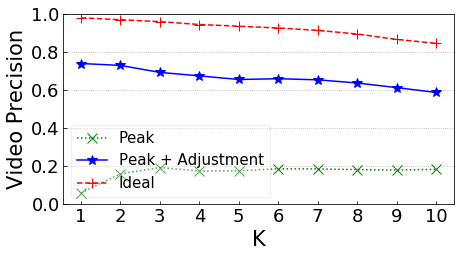

[[[0.06, 0.16, 0.19333333333333333, 0.175, 0.176, 0.18666666666666668, 0.18571428571428572, 0.1825, 0.18, 0.184], 'xg:', 'Peak'], [[0.74, 0.73, 0.6933333333333334, 0.675, 0.656, 0.66, 0.6542857142857142, 0.6375, 0.6133333333333333, 0.588], '*b-', 'Peak + Adjustment'], [[0.98, 0.97, 0.96, 0.945, 0.936, 0.9266666666666666, 0.9142857142857143, 0.895, 0.8666666666666667, 0.846], '+r--', 'Ideal']]


In [12]:
dota2_test_data = DataLoader('Dota2', 'test', **INITIAL_PARA)
apply_model(dota2_model3, dota2_test_data, 120, [4, 5, 6])
expander.const[0] = optimal
expander.generate_peaks(dota2_test_data, **EXPAND)
expander.apply(dota2_test_data)

k = 10

no_moving = []
moving = []
ideal = []
for i in range(1, k + 1):
    true_num = [0, 0, 0]
    for f in dota2_test_data.predicted_labels:
        true_labels = [sec(j) for j in dota2_test_data.baseline_gt[f]]
        true_num[0] += len([p[0] for p in dota2_test_data.predicted_labels[f][:i] if p[0] in true_labels])
        true_num[1] += len([p[0] for p in dota2_test_data.predicted_labels[f][:i] if p[-1] in dota2_test_data.start_gt[f]])       
        true_num[2] += len([p[0] for p in dota2_test_data.predicted_labels[f][:i] if p[-2] in dota2_test_data.start_gt[f]])
        
    no_moving.append(true_num[2] / float(i * len(dota2_test_data.predicted_labels)))
    moving.append(true_num[1] / float(i * len(dota2_test_data.predicted_labels)))
    ideal.append(true_num[0] / float(i * len(dota2_test_data.predicted_labels)))


prec_list = [[no_moving, 'xg:', 'Peak'],
             [moving, '*b-', 'Peak + Adjustment'],
             [ideal, '+r--', 'Ideal']
            ]
plot_precision(prec_list, 'K', 'Video Precision', list(range(1, k + 1)), [0, 1], np.arange(0.0, 1.1, 0.2))
print(prec_list)

# Exp for Figure 7

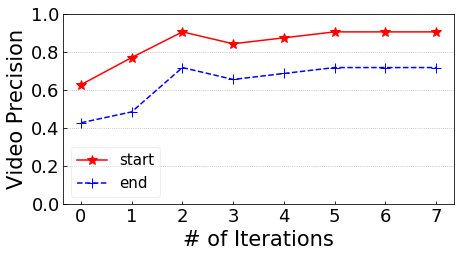

[[[0.6285714285714286, 0.7714285714285715, 0.90625, 0.84375, 0.875, 0.90625, 0.90625, 0.90625], '-r*', 'start'], [[0.42857142857142855, 0.4857142857142857, 0.71875, 0.65625, 0.6875, 0.71875, 0.71875, 0.71875], '--b+', 'end']]


In [13]:
highlight_extractor = Highlight_Extractor(ORIGINAL_DATA)
highlight_extractor.process_all_iterations()

crowd_data = {}
for t in highlight_extractor.data_lineage:
    for m in highlight_extractor.data_lineage[t]:
        crowd_data[m] = highlight_extractor.data_lineage[t][m]

# end_gt = {}
# for f in dota2_test_data.gt:
#     end_gt[f] = []
#     for i in dota2_test_data.gt[f]:
#         end_gt[f] += list(range(i, i + 11))
#     end_gt[f] = list(set(end_gt[f]))
    

iternum = 7
pre = []
for i in range(0, iternum + 1):
    p = [0, 0, 0]
    for m in crowd_data:
        f = DOTA2_MOVIE_NAME_BY_ID[m]   
        l = len(crowd_data[m]) - 2
        s = 0
        e = 0
        if m in highlight_extractor.data_lineage['selected']:
            if i < l:
                s = crowd_data[m][i][0]
                e = crowd_data[m][i][1] if crowd_data[m][i][1] > 0 else s + expander.const[1]
            else:
                s = crowd_data[m][-1][0]
                e = crowd_data[m][-1][1]
            p[2] += 1
            if s in dota2_test_data.start_gt[f]:
                p[0] += 1
            if e in dota2_test_data.end_gt[f]:
                p[1] += 1
        else:
            if i < l:
                s = crowd_data[m][i][0]
                e = crowd_data[m][i][1] if crowd_data[m][i - 1][1] > 0 else s + expander.const[1]
                p[2] += 1
                if s in dota2_test_data.start_gt[f]:
                    p[0] += 1
                if e in dota2_test_data.end_gt[f]:
                    p[1] += 1
    pre.append(p)
start = [i[0] / i[2] for i in pre]
end = [i[1] / i[2] for i in pre]

crowd_plot = [
    [start, '-r*', 'start'],
    [end, '--b+', 'end']
]

plot_precision(crowd_plot, '# of Iterations', 'Video Precision', list(range(0, iternum + 1)), [0, 1], np.arange(0, 1.1, 0.2))
print(crowd_plot)

# Exp for Figure 8

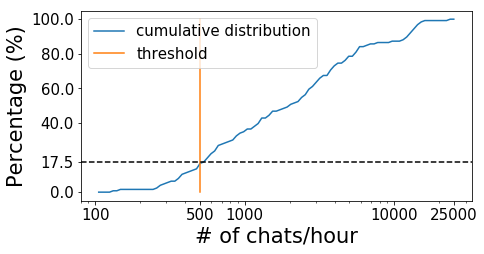

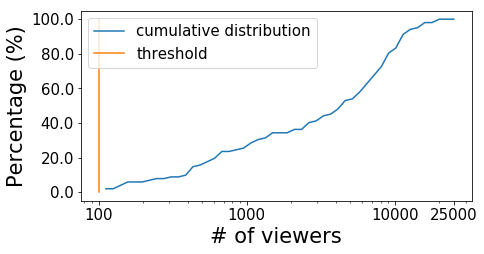

<Figure size 432x288 with 0 Axes>

In [14]:
plot_trends()

# Exp for Figure 9

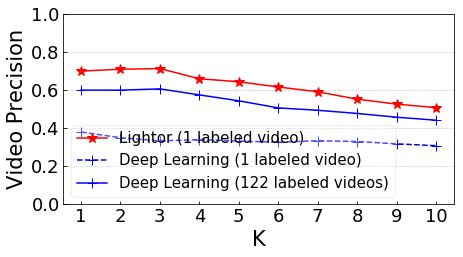

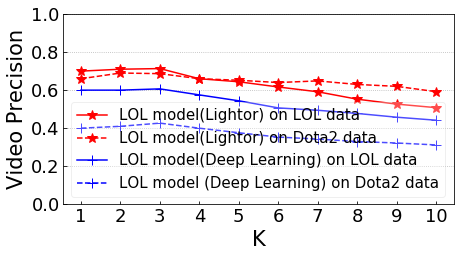

[[[0.7, 0.71, 0.7133333333333334, 0.66, 0.644, 0.6166666666666667, 0.5914285714285714, 0.5525, 0.5266666666666666, 0.508], '-r*', 'Lightor (1 labeled video)'], [[0.38, 0.35, 0.3333333333333333, 0.34, 0.332, 0.32666666666666666, 0.3342857142857143, 0.33, 0.31777777777777777, 0.308], '--b+', 'Deep Learning (1 labeled video)'], [[0.6, 0.6, 0.6066666666666667, 0.575, 0.544, 0.5066666666666667, 0.4942857142857143, 0.4775, 0.4577777777777778, 0.442], '-b+', 'Deep Learning (122 labeled videos)']]
[[[0.7, 0.71, 0.7133333333333334, 0.66, 0.644, 0.6166666666666667, 0.5914285714285714, 0.5525, 0.5266666666666666, 0.508], '-r*', 'LOL model(Lightor) on LOL data'], [[0.66, 0.69, 0.6866666666666666, 0.66, 0.652, 0.64, 0.6485714285714286, 0.63, 0.62, 0.592], '--r*', 'LOL model(Lightor) on Dota2 data'], [[0.6, 0.6, 0.6066666666666667, 0.575, 0.544, 0.5066666666666667, 0.4942857142857143, 0.4775, 0.4577777777777778, 0.442], '-b+', 'LOL model(Deep Learning) on LOL data'], [[0.4, 0.41, 0.4266666666666667,

In [15]:
k = 10
expander = Adjustment(lol_train_data, **EXPAND)
expander.train()

lol_on_lol_DL_122, _ = evaluate_baseline(k, 'LOL_122_labels', lol_test_data)
lol_on_lol_DL_1, _ = evaluate_baseline(k, 'LOL_1_label', lol_test_data)
lol_on_dota_DL_122, _ = evaluate_baseline(k, 'Dota2_122_labels', dota2_test_data)
lol_on_dota_DL_1, _ = evaluate_baseline(k, 'Dota2_1_label', dota2_test_data)


lol_on_lol_lightor = []
lol_on_dota_lightor = []



apply_model(lol_model, lol_test_data, 120, [4, 5, 6])
apply_model(lol_model, dota2_test_data, 120, [4, 5, 6])
expander.generate_peaks(dota2_test_data, **EXPAND)
expander.apply(dota2_test_data)
expander.generate_peaks(lol_test_data, **EXPAND)
expander.apply(lol_test_data)

for i in range(1, k + 1):
    true_num = [0, 0]
    for f in lol_test_data.chat:
        pred = lol_test_data.predicted_labels[f][:i]
        true_num[0] += len([p for p in pred if p[-1] in lol_test_data.start_gt[f]])
        
    for f in dota2_test_data.chat:
        pred = dota2_test_data.predicted_labels[f][:i]
        true_num[1] += len([p for p in pred if p[-1] in dota2_test_data.start_gt[f]])
    lol_on_lol_lightor.append(true_num[0] / float(i * len(lol_test_data.predicted_labels)))
    lol_on_dota_lightor.append(true_num[1] / float(i * len(dota2_test_data.predicted_labels)))

data_size_plot = [
    [lol_on_lol_lightor, '-r*', 'Lightor (1 labeled video)'],
    [lol_on_lol_DL_1, '--b+', 'Deep Learning (1 labeled video)'],
    [lol_on_lol_DL_122, '-b+', 'Deep Learning (122 labeled videos)']
]

generalization_plot = [
    [lol_on_lol_lightor, '-r*', 'LOL model(Lightor) on LOL data'],
    [lol_on_dota_lightor, '--r*', 'LOL model(Lightor) on Dota2 data'],
    [lol_on_lol_DL_122, '-b+', 'LOL model(Deep Learning) on LOL data'],
    [lol_on_dota_DL_122, '--b+', 'LOL model (Deep Learning) on Dota2 data']
]

plot_precision(data_size_plot, 'K', 'Video Precision', list(range(1, k + 1)), [0, 1], np.arange(0, 1.1, 0.2))
plot_precision(generalization_plot, 'K', 'Video Precision', list(range(1, k + 1)), [0, 1], np.arange(0, 1.1, 0.2))

print(data_size_plot)
print(generalization_plot)